# 1 Variational Autoencoder

In [2]:
import os

import pyro
import pyro.distributions as D
import pyro.contrib.examples.util 
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as T

In [3]:
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

In [4]:
def setup_dataloaders(batch_size=128):
    root = './data/01_vae/'
    download = True
    
    trans = T.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [5]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 784)
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        return self.sigmoid(self.fc2(hidden))

In [6]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        self.softplus = nn.Softplus()
        
    def forward(self, x):
        x = x.reshape(-1, 784)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [7]:
def _model(self, x:torch.Tensor):
    pyro.module('decoder', self.decoder)
    with pyro.plate('data', x.size(0)):
        z_loc = x.new_zeros(torch.Size((x.size[0], self.z_dim)))
        z_scale = x.new_ones(torch.Size((x.size[0], self.z_dim)))
        
        z = pyro.sample('latent', D.Normal(z_loc, z_scale))
        loc_img = self.decoder(z)
        
        pyro.sample('obs', D.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

In [8]:
def _guide(self, x:torch.Tensor):
    pyro.module('encoder', self.encoder)
    with pyro.plate('data', x.size(0)):
        z_loc, z_scale = self.encoder(x)
        pyro.sample('latent', D.Normal(z_loc, z_scale))

In [9]:
class VAE(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=400):
        super().__init__()
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        self.z_dim = z_dim
        
    def model(self, x:torch.Tensor):
        pyro.module('decoder', self.decoder)
        with pyro.plate('data', x.size(0)):
            z_loc = x.new_zeros((x.size(0), self.z_dim))
            z_scale = x.new_ones((x.size(0), self.z_dim))
            
            z = pyro.sample('latent', D.Normal(z_loc, z_scale).to_event(1))
            loc_img = self.decoder(z)
            pyro.sample('obs', D.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            return loc_img
        
    def guide(self, x:torch.Tensor):
        pyro.module('encoder', self.encoder)
        with pyro.plate('data', x.size(0)):
            z_loc, z_scale = self.encoder(x)
            pyro.sample('latent', D.Normal(z_loc, z_scale).to_event(1))
            
    def reconstruct_img(self, x):
        z_loc, z_scale = self.encoder(x)
        z = D.Normal(z_loc, z_scale).sample()
        return self.decoder(z)

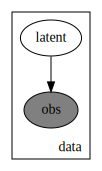

In [10]:
pyro.render_model(VAE().model, (torch.ones(2, 28, 28), ))

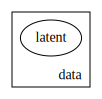

In [11]:
pyro.render_model(VAE().guide, (torch.ones(2, 28, 28), ))

In [12]:
vae = VAE()

In [13]:
optimizer = Adam({'lr': 1e-3})

In [14]:
svi = SVI(vae.model, vae.guide, optimizer, Trace_ELBO())

In [15]:
def train(svi, train_loader):
    loss_ = 0
    for x, _ in train_loader:
        loss_ += svi.step(x)
        
    loss_ /= len(train_loader.dataset)
    return loss_ 
        

In [16]:
def evaluate(svi, test_loader):
    loss_ = 0
    for x, _ in test_loader:
        loss_ += svi.step(x)
    
    return loss_ / len(test_loader.dataset)

In [17]:
from tqdm import trange

In [18]:
train_loader, test_loader = setup_dataloaders(batch_size=256)

pyro.clear_param_store()

vae = VAE()

optimizer = Adam({'lr': 1e-3})

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []

for epoch in trange(100):
    train_elbo.append(-train(svi, train_loader))
    if epoch % 5 == 0:
        test_elbo += [-evaluate(svi, test_loader)] * 5

100%|██████████| 100/100 [18:01<00:00, 10.82s/it]


In [19]:
import matplotlib.pyplot as plt

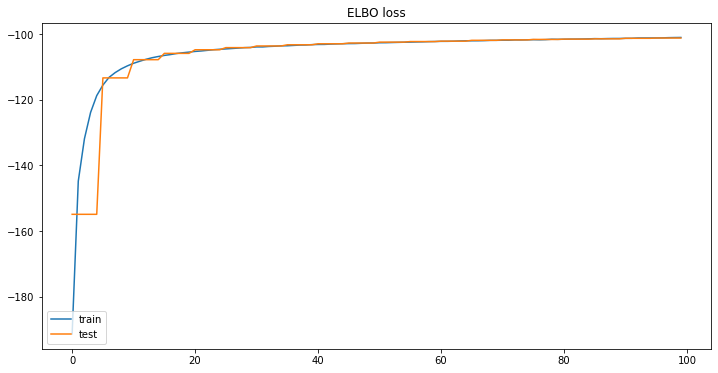

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(train_elbo, label='train')
plt.plot(test_elbo, label='test')
plt.title('ELBO loss')
plt.legend(loc='lower left')
plt.show()
plt.close()

In [21]:
_, test_loader = setup_dataloaders(batch_size=16)

imgs, _ = iter(test_loader).next()

recon = vae.reconstruct_img(imgs).reshape(16, 28, 28)
recon.shape

torch.Size([16, 28, 28])

In [22]:
trans = T.ToPILImage()

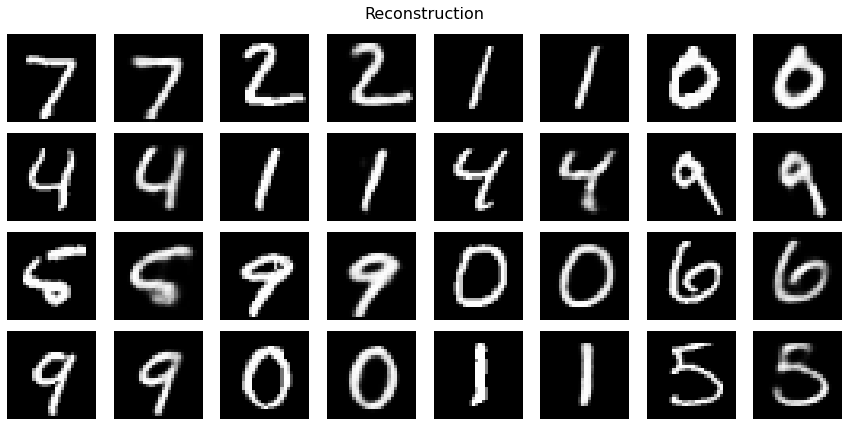

In [23]:
plt.figure(figsize=(12, 6))

for k in range(1, 17):
    plt.subplot(4, 8, 2 * k - 1)
    plt.imshow(trans(imgs[k-1]), cmap='gray')
    plt.axis('off')
    
    plt.subplot(4, 8, 2 * k)
    plt.imshow(trans(recon[k-1]), cmap='gray')
    plt.axis('off')
    
plt.suptitle('Reconstruction', fontsize=16)
plt.tight_layout()
plt.show()
plt.close()
    

In [24]:
x = torch.zeros(32, 784)
gen = vae.model(x).reshape(32, 28, 28)

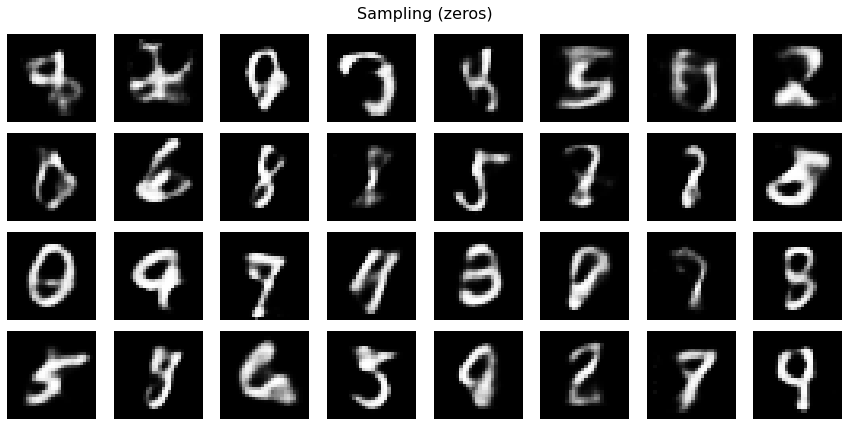

In [25]:
plt.figure(figsize=(12, 6))

for k in range(1, 33):
    plt.subplot(4, 8, k)
    plt.imshow(trans(gen[k-1]), cmap='gray')
    plt.axis('off')
    
plt.suptitle('Sampling (zeros)', fontsize=16)
plt.tight_layout()
plt.show()
plt.close()

In [26]:
x = torch.rand(32, 784)
gen = vae.model(x).reshape(32, 28, 28)

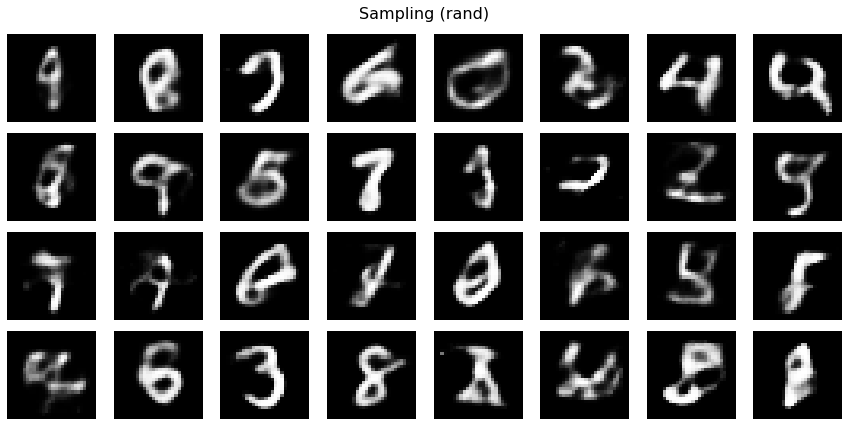

In [27]:
plt.figure(figsize=(12, 6))

for k in range(1, 33):
    plt.subplot(4, 8, k)
    plt.imshow(trans(gen[k-1]), cmap='gray')
    plt.axis('off')
    
plt.suptitle('Sampling (rand)', fontsize=16)
plt.tight_layout()
plt.show()
plt.close()